## Sentinel-1 RTC Gamma0 data <img align="right" src="../../resources/csiro_easi_logo.png">

#### Index
- [Overview](#Overview)
- [Setup (imports, defaults, dask, odc)](#Setup)
- [Example query](#Example-query)
- [Water detection](#Water_detection)
 - [Thresholding](#Thresholding) 

## Overview

This notebook demonstrates how to load and use Sentinel-1 Radiometric Terrain Corrected (RTC) Gamma0 data generated in EASI.

These _analysis ready data_ S1 gamma-0 backscatter data are processed from Sentinel-1 GRD scenes using the [SNAP-10 Toolbox](https://step.esa.int/main/download/snap-download/) with Graph Processing Tool (GPT) xml receipes. See the [RTC Gamma0 product variants](#RTC-Gamma0-product-variants) section for further details.

For most uses we recommend the smoothed 20 m product (`sentinel1_grd_gamma0_20m`).
We can process the 10 m products (`sentinel1_grd_gamma0_10m`, `sentinel1_grd_gamma0_10m_unsmooth`) and other variants on request.

#### Using Sentinel-1 backscatter data

An excellent introduction and overview to using SAR data is provided in the [CEOS Laymans SAR Interpretation Guide](https://ceos.org/ard/files/Laymans_SAR_Interpretation_Guide_3.0.pdf). This guide has also been converted to a set of set of Jupyter notebooks that you can download from https://github.com/AMA-Labs/cal-notebooks/tree/main/examples/SAR.

Synthetic Aperture Radar operates in the microwave range of the electromagnetic spectrum as an active pulse sent by the satellite and scattered by features on the Earth's surface. The return signal from the surface is measured at the satellite in terms of the signal intensity, phase and polarisation compared to the signal that was sent.

The SAR instrument on the Sentinel-1 satellites operate in the C-band at approximately 5.6 cm wavelength. This means that it can "see" objects of about this size and larger, and smaller objects are relatively transparent. This makes Sentinel-1 more sensitive to tree canopies, sparse and low biomass vegetation, and surface water (smooth and wind affected).

> The SAR signal responds to the orientation and scattering from surface features of comparable size or larger than the wavelength.
> - A bright backscatter value typically means the surface was orientated perpendicular to the signal incidence angle and most of the signal was reflected back to the satellite (direct backscatter)
> - A dark backscatter value means most of the signal was reflected away from the satellite (forward scattering) and typically responds to a smooth surface (relative to the wavelength) such as calm water or bare soil
> - Rough surfaces (relative to the wavelength) result in diffuse scattering where some of the signal is returned to the satellite.
> - Complex surfaces may result in volume scattering (scattering within a tree canopy) or double-bounce scattering (perpendicular objects such as buildings and structures)
> - The relative backscatter values of co-polarisation (VV) and cross-polarisation (VH) measurements can provide information on the scattering characteristics of the surface features.

Using Sentinel-1 backscatter data requires interpretation of the data for different surface features, including as these features change spatially or in time. It may also be necessary to carefully consider the incidence angle of the SAR signal relative to the surface features using the _incidence_angle_ band or the satellite direction metadata (descending = north to south; ascending = south to north).

#### Units and conversions
The `sentinel1_grd_gamma0_*` data are given in _Intensity_ (or backscatter _power_) units. Intensity can be converted to _decibel (dB)_ or _amplitude_, and vice-versa, with the following equations. Practical _Xarray_ examples are given below.

Intensity to/from dB:
```
       dB = 10 * log10(intensity) + K
intensity = 10^((dB-K)/10)

where K is a calibration factor, which for Sentinel-1 is 0 dB.
```

Intensity to/from Amplitude:
```
intensity = amplitude * amplitude
amplitude = sqrt(intensity)
```

Additional reference: https://forum.step.esa.int/t/what-stage-of-processing-requires-the-linear-to-from-db-command

## Set up

#### Imports

In [48]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import numpy as np

# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                             # https://github.com/opendatacube/odc-geo
from datacube.utils import masking            # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from dea_tools.plotting import display_map    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools

# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.xarray
import panel as pn

In [2]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
repo = '/home/jovyan/easi-notebooks/easi-notebooks/'
if repo not in sys.path: sys.path.append(repo)
from easi_tools import EasiDefaults, notebook_utils
# from easi_tools import initialize_dask, xarray_object_size, heading

#### EASI defaults

These default values are configured for each EASI instance. They help us to use the same training notebooks in each EASI instance. You may find some of the functions convenient for your work or you can easily override the values in your copy of this notebook.

In [8]:
easi = EasiDefaults()

family = 'sentinel-1'
product = 'sentinel1_grd_gamma0_20m'   # 'sentinel1_grd_gamma0_20m'
display(Markdown(f'Default {family} product for "{easi.name}": [{product}]({easi.explorer}/products/{product})'))

Successfully found configuration for deployment "asia"


Default sentinel-1 product for "asia": [sentinel1_grd_gamma0_20m](https://explorer.asia.easi-eo.solutions/products/sentinel1_grd_gamma0_20m)

#### Dask cluster

Using a local _Dask_ cluster is a good habit to get into. It can simplify loading and processing of data in many cases, and it provides a dashboard that shows the loading/processing progress.

To learn more about _Dask_ see the set of [dask notebooks](https://github.com/csiro-easi/easi-notebooks/tree/main/html#dask-tutorials).

In [4]:
# Local cluster
# cluster, client = initialize_dask(workers=4)
# display(client)

# Or use Dask Gateway - this may take a few minutes
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=4)
display(client)

An existing cluster was found. Connecting to: easihub.009c6395aed646e9928448141c1997ba


<Client: 'tls://10.0.34.133:8786' processes=4 threads=32, memory=112.00 GiB>

#### ODC database

Connect to the ODC database. Configure the environment and low-level tools to read from AWS buckets.

In [9]:
dc = datacube.Datacube()

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

## Example query

Change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.

Use the Explorer interface to check the temporal and spatial coverage for each product.

In [50]:
# Explorer link
display(Markdown(f'See: {easi.explorer}/products/{product}'))

# Bangladesh
latitude = (22, 22.5)
longitude = (88.5, 89.0)
time = ('2024-07-01', '2024-07-31')

query = {
    'product': product,       # Product name
    'x': longitude,     # "x" axis bounds
    'y': latitude,      # "y" axis bounds
    'time': time,       # Any parsable date strings
}

# Convenience function to display the selected area of interest
display_map(longitude, latitude)

See: https://explorer.asia.easi-eo.solutions/products/sentinel1_grd_gamma0_20m

## Load data

In [51]:
# Target xarray parameters
# - Select a set of measurements to load
# - output CRS and resolution
# - Usually we group input scenes on the same day to a single time layer (groupby)
# - Select a reasonable Dask chunk size (this should be adjusted depending on the
#   spatial and resolution parameters you choose
load_params = {
    'group_by': 'solar_day',                        # Scene grouping
    'dask_chunks': {'latitude':180, 'longitude':180},      # Dask chunks
}

# Load data
data = dc.load(**(query | load_params))
display(notebook_utils.xarray_object_size(data))
display(data)

'Dataset size: 143.09 MB'

<xarray.Dataset> Size: 150MB
Dimensions:      (time: 2, latitude: 2500, longitude: 2500)
Coordinates:
  * time         (time) datetime64[ns] 16B 2024-07-09T12:12:36.500000 2024-07...
  * latitude     (latitude) float64 20kB 22.5 22.5 22.5 22.5 ... 22.0 22.0 22.0
  * longitude    (longitude) float64 20kB 88.5 88.5 88.5 88.5 ... 89.0 89.0 89.0
    spatial_ref  int32 4B 4326
Data variables:
    vh           (time, latitude, longitude) float32 50MB dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    vv           (time, latitude, longitude) float32 50MB dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
    angle        (time, latitude, longitude) float32 50MB dask.array<chunksize=(1, 180, 180), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [52]:
# When happy with the shape and size of chunks, persist() the result
data = data.persist()

## Conversion and helper functions

In [53]:
# These functions use numpy, which should be satisfactory for most notebooks.
# Calculations for larger or more complex arrays may require Xarray's "ufunc" capability.
# https://docs.xarray.dev/en/stable/examples/apply_ufunc_vectorize_1d.html
#
# Apply numpy.log10 to the DataArray
# log10_data = xr.apply_ufunc(np.log10, data)

def intensity_to_db(da: 'xr.DataArray', K=0):
    """Return an array converted to dB values"""
    xx = da.where(da > 0, np.nan)  # Set values <= 0 to NaN
    xx = 10*np.log10(xx) + K
    xx.attrs.update({"units": "dB"})
    return xx

def db_to_intensity(da: 'xr.DataArray', K=0):
    """Return an array converted to intensity values"""
    xx = np.power(10, (da-K)/10.0)
    xx.attrs.update({"units": "intensity"})
    return xx

def select_valid_time_layers(ds: 'xarray', percent: float = 5):
    """Select time layers that have at least a given percentage of valid data (e.g., >=5%)

    Example usage:
      selected = select_valid_time_layers(ds, percent=5)
      filtered == ds.sel(time=selected)
    """
    spatial_dims = ds.odc.spatial_dims
    return ds.count(dim=spatial_dims).values / (ds.sizes[spatial_dims[0]]*ds.sizes[spatial_dims[1]]) >= (percent/100.0)

# Examples to check that the intensity to/from dB functions work as expected
# xx = data.vv.isel(time=0,latitude=np.arange(0, 5),longitude=np.arange(0, 5))
# xx[0] = 0
# xx[1] = -0.001
# display(xx.values)
# yy = intensity_to_db(xx)
# display(yy.values)
# zz = db_to_intensity(yy)
# display(zz.values)

In [54]:
# hvPlot convenience functions
def make_image(ds: 'xarray', frame_height=300, **kwargs):
    """Return a Holoviews DynamicMap (image) object that can be displayed or combined"""
    spatial_dims = ds.odc.spatial_dims
    defaults = dict(
        cmap="Greys_r",
        y = spatial_dims[0], x = spatial_dims[1],
        groupby = 'time',
        rasterize = True,
        geo = True,
        robust = True,
        frame_height = frame_height,
        clabel = ds.attrs.get('units', None),
    )
    defaults.update(**kwargs)
    return ds.hvplot.image(**defaults)

def rgb_image(ds: 'xarray', frame_height=300, **kwargs):
    """Return a Holoviews DynamicMap (RBG image) object that can be displayed or combined"""
    spatial_dims = ds.odc.spatial_dims
    defaults = dict(
        bands='band',
        y = spatial_dims[0], x = spatial_dims[1],
        groupby = 'time',
        rasterize = True,
        geo = True,
        robust = True,
        frame_height = frame_height,
    )
    defaults.update(**kwargs)
    return ds.hvplot.rgb(**defaults)

In [55]:
# Optional time layer filter

selected = select_valid_time_layers(data.vv, 10)  # Exclude time layers with less than 10% valid data
data = data.sel(time=selected).persist()

In [56]:
# Add db values to the dataset

data['vh_db'] = intensity_to_db(data.vh).persist()
data['vv_db'] = intensity_to_db(data.vv).persist()

## Plot the data

> Note the different data ranges for plotting (`clim`) between `vv`, `vh`, _intensity_ and _dB_.

- Stronger co-polarisation (VV) indicates direct backscatter while stronger cross-polarisation (VH) may indicate a complex surface or volume scattering.
- Intensity data are linear-scaled so can tend to disciminate across a range of backscatter returns.
- Decibel data are log-scaled so can tend to discriminate high and low backscatter returns.

In [57]:
# VV and VH (intensity and dB) and Angle hvPlots

vv_plot = make_image(data.vv, clim=(0, 0.3), title='VV')
vh_plot = make_image(data.vh, clim=(0, 0.05), title='VH')
ia_plot = make_image(data.angle, title='Incidence angle')

vv_db_plot = make_image(data.vv_db, clim=(-30, -10), title='VV')
vh_db_plot = make_image(data.vh_db, clim=(-30, -20), title='VH')

In [58]:
# Arrange plots with linked axes and time slider. Adjust browser window width if required.

layout = pn.panel(
    (vv_plot + vh_plot + ia_plot + vv_db_plot + vh_db_plot).cols(3),
    widget_location='top',
)
print(layout)  # Helpful to see how the hvplot is constructed
layout

Column
    [0] WidgetBox(align=('center', 'start'))
        [0] DiscreteSlider(name='time (seconds s..., options={'2024-07-09 12:12:36': nu...}, value=numpy.datetime64('2024-07-...)
    [1] HoloViews(Layout, widget_location='top')


Column
    [0] WidgetBox(align=('center', 'start'))
        [0] DiscreteSlider(name='time (seconds s..., options={'2024-07-09 12:12:36': nu...}, value=numpy.datetime64('2024-07-...)
    [1] HoloViews(Layout, widget_location='top')

## Plot a histogram of the dB data

A histogram can help separate water from land features. Here we show a histogram for the _VH (db)_ channel for all time layers.
- If the histogram shows two clear peaks then a value between the peaks could be used as a water / land threshold
- If not then try selected time layers, a different area of interest, or other channels or combinations.
- Water has low backscatter, the VH polarisation has even lower backscatter over water than the VV polarization. 

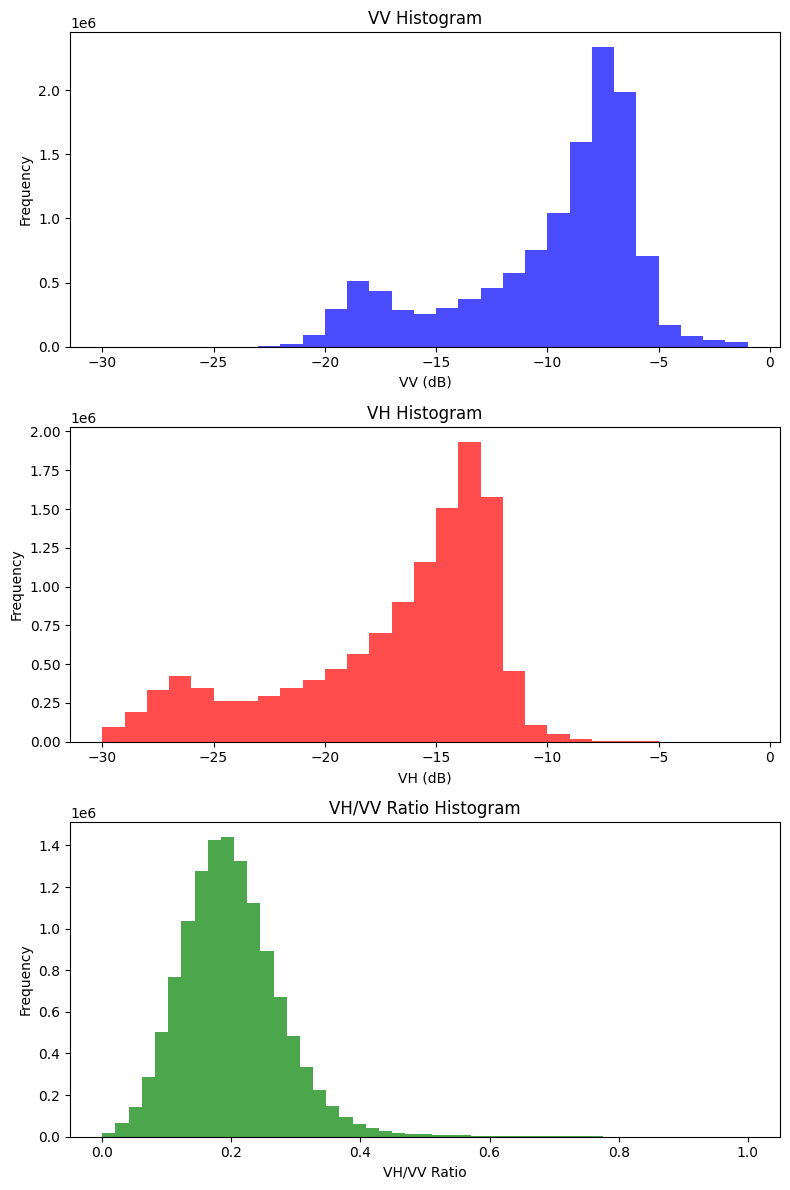

In [64]:
# Define bins
bins = np.arange(-30, 0, 1)

# Create figure with 3 rows, 1 column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
# VV Histogram
axes[0].hist(data.vv_db.values.flatten(), bins=bins, color='blue', alpha=0.7)
axes[0].set_title('VV Histogram')
axes[0].set_xlabel('VV (dB)')
axes[0].set_ylabel('Frequency')

# VH Histogram
axes[1].hist(data.vh_db.values.flatten(), bins=bins, color='red', alpha=0.7)
axes[1].set_title('VH Histogram')
axes[1].set_xlabel('VH (dB)')
axes[1].set_ylabel('Frequency')

# VH/VV Ratio Histogram (converted from dB to linear scale)
vh_vv_ratio = 10**(data.vh_db / 10) / 10**(data.vv_db / 10)
axes[2].hist(vh_vv_ratio.values.flatten(), bins=np.linspace(0, 1, 50), color='green', alpha=0.7)
axes[2].set_title('VH/VV Ratio Histogram')
axes[2].set_xlabel('VH/VV Ratio')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

## Make an RGB image

A common strategy to create an RGB colour composite image for SAR data from two channels is to use the ratio of the channels to represent the third colour. Here we choose

To create an RGB colour composite image we can use the ratio of VH and VH to represent a third channel. Here we choose
- Red = VH ... complex scattering
- Green = VV ... direct scattering
- Blue = VH/VV ... relatively more complex than direct

In [60]:
# Add the vh/vv band to represent 'blue'
data['vh_vv'] = data.vh / data.vv

# Scale the measurements by their median so they have a similar range for visualization
spatial_dims = data.odc.spatial_dims
data['vh_scaled'] = data.vh / data.vh.median(dim=spatial_dims).persist()
data['vv_scaled'] = data.vv / data.vv.median(dim=spatial_dims).persist()
data['vh_vv_scaled'] = data.vh_vv / data.vh_vv.median(dim=spatial_dims).persist()

# odc-geo function
rgb_data = data.odc.to_rgba(bands=['vh_scaled','vv_scaled','vh_vv_scaled'], vmin=0, vmax=4)

In [61]:
# As subplots
# rgb_plot = rgb_image(
#     rgb_data,
# ).layout().cols(4)

# As movie. Select "loop" and use "-" button to adjust the speed to allow for rendering. After a few cycles the images should play reasonably well.
rgb_plot = rgb_image(
    rgb_data,
    precompute = True,
    widget_type='scrubber', widget_location='bottom',
    frame_height = 500,
)

print(rgb_plot)  # Helpful to see how the hvplot is constructed
rgb_plot

Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=1, width=550)


Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=1, width=550)

# Water detection
## Thresholding

We will try a thresholding method which is a simple and effective method based on empirical thresholds. If we look at the histograms of each polarization, low backscatter for VV < -18 dB, for VH < -25 dB and VH/VV < 0.3 (linear scale)

In [73]:
# Define thresholds for water (values depend on region, may need tuning)
vv_threshold = -18  # VV in dB
vh_threshold = -25  # VH in dB
vh_vv_threshold = 0.3  # VH/VV ratio in linear scale

# Apply threshold-based classification
water_mask = (data.vv_db < vv_threshold) & (data.vh_db < vh_threshold) & (vh_vv_ratio < vh_vv_threshold).persist()
water_mask

<xarray.DataArray (time: 2, latitude: 2500, longitude: 2500)> Size: 12MB
dask.array<and_, shape=(2, 2500, 2500), dtype=bool, chunksize=(1, 180, 180), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 16B 2024-07-09T12:12:36.500000 2024-07...
  * latitude     (latitude) float64 20kB 22.5 22.5 22.5 22.5 ... 22.0 22.0 22.0
  * longitude    (longitude) float64 20kB 88.5 88.5 88.5 88.5 ... 89.0 89.0 89.0
    spatial_ref  int32 4B 4326

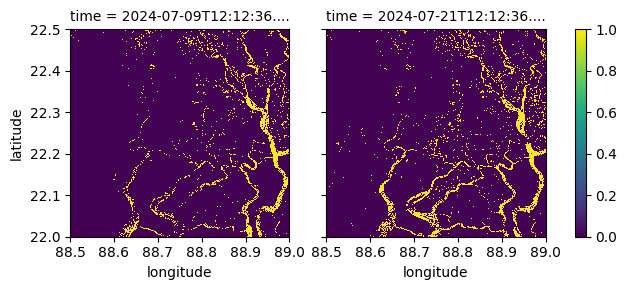

In [74]:
# Visualize results
water_mask.plot(col='time', col_wrap=2)
plt.show()

# Export to Geotiffs

Recall that to write a dask dataset to a file requires the dataset to be `.compute()`ed. This may result in a large memory increase on your JupyterLab node if the area of interest is large enough, which in turn may kill the kernel. If so then skip this step, choose a smaller area or find a different way to export data.

In [ ]:
# Make a directory to save outputs to
target = Path.home() / 'output'
if not target.exists(): target.mkdir()

def write_band(ds, varname):
    """Write the variable name of the xarray dataset to a Geotiff files for each time layer"""
    for i in range(len(ds.time)):
        date = ds[varname].isel(time=i).time.dt.strftime('%Y%m%d').data
        single = ds[varname].isel(time=i).compute()
        single.odc.write_cog(
            fname=f'{target}/example_sentinel-1_{varname}_{date}.tif',
            overwrite=True,
        )
        
write_band(data, 'vv')
write_band(data, 'vh')

# Appendix

### RTC Gamma0 product variants

The set of products listed here differ by the selection and configuration of processing steps and options. The set of SNAP operators conform with [CEOS Analysis Ready Data](https://ceos.org/ard/) specifications for _normalised radar backscatter_.

S1 gamma-0 backscatter data are processed from Sentinel-1 GRD scenes using the [SNAP-10 Toolbox](https://step.esa.int/main/download/snap-download/) with Graph Processing Tool (GPT) xml receipes (available on request).

| | sentinel1_grd_gamma0_20m | sentinel1_grd_gamma0_10m | sentinel1_grd_gamma0_10m_unsmooth |
|--|--|--|--|
| **DEM** | | | |
| copernicus_dem_30 | Y | Y | Y |
| Scene to DEM extent multiplier| 3.0 | 3.0 | 3.0 |
| **SNAP operator** | | | |
| Apply-Orbit-File | Y | Y | Y |
| ThermalNoiseRemoval | Y | Y | Y |
| Remove-GRD-Border-Noise | Y | Y | Y |
| Calibration | Y | Y | Y |
| SetNoDataValue | Y | Y | Y |
| Terrain-Flattening | Y | Y | Y |
| Speckle-Filter | Y | Y | N |
| Multilook | Y | Y | N |
| Terrain-Correction | Y | Y | Y |
| **Output** | | | |
| Projection | WGS84, epsg:4326 | WGS84, epsg:4326 | WGS84, epsg:4326 |
| Pixel resolution | 20 m | 10 m | 10 m |
| Pixel alignment</br>_PixelIsArea = top-left_ | PixelIsArea | PixelIsArea | PixelIsArea |